## Config

In [ ]:
!pip install lifelines
!pip install gspread

In [ ]:
!pip install gspreadfrom dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta, date
import pandas as pd
from google.cloud import bigquery
import random
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np
from scipy.optimize import curve_fit
from google.colab import auth

ERROR: Could not find a version that satisfies the requirement gspreadfrom (from versions: none)
ERROR: No matching distribution found for gspreadfrom


In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project='indy-eng')

In [ ]:
# This map is needed to translate trial_duration into trial_duration in months
cadence_map = {
    "day": 1,
    "Staging test": 0,
    "week": 1,
    "2 week": 1,
    "month": 1,
    "quarter": 3,
    "6 month":  6,
    "year": 12,
    "3 year": 36,
    "No trial": 0
}

In [ ]:
subs_details_rundate = "2025-10-17"

# Retention Curves

## Creating Retention Curves

In [ ]:
# Dimensions used to create categorisation of our new retention curves
splits = [
    "package_type",
    "trial_duration_months",
    "term_cadence",
]

splits_str = ", ".join(splits)

In [ ]:
query = f"""

WITH fixed_expiry_date_df AS (
    SELECT * EXCEPT(user_access_expiration_date),
    CASE WHEN LOWER(piano_status) LIKE 'payment failure'
    # Move the expiry date up by 28 days for payment failures as these individuals will not have payed for their last 28 days of the subscription
    OR (LOWER(piano_status) LIKE 'active' AND subscription_grace_period_start_date IS NOT NULL AND RAND() < 0.8)
    THEN DATE_SUB(user_access_expiration_date, INTERVAL 28 DAY)
    ELSE user_access_expiration_date END AS fixed_expiry_date
    FROM
    `indy-eng.reader_revenue_dataform.subscription_details_snapshots_enhanced`
    WHERE
        run_date = "{subs_details_rundate}"
)

SELECT

    {splits_str},

    CAST(
        CASE
            WHEN CAST(fixed_expiry_date AS DATE) > "{subs_details_rundate}"
            #NOTE SOME USERS DO NOT SEEM TO HAVE AN EXPIRY DATE - DYNAMIC ISSUE, IN ANY CASE STILL NEED TO BE ADDED
            OR fixed_expiry_date IS NULL
            THEN DATE_DIFF("{subs_details_rundate}", CAST(start_date AS DATE), MONTH)
            ELSE
                DATE_DIFF(CAST(fixed_expiry_date AS DATE), CAST(start_date AS DATE), MONTH)
        END AS FLOAT64
    ) AS duration,

    CASE
        WHEN CAST(fixed_expiry_date AS DATE) < "{subs_details_rundate}" THEN 1
        ELSE 0
    END AS churned

FROM
    fixed_expiry_date_df

WHERE
  customer_type NOT LIKE "Test"
  AND LOWER(package_type) NOT LIKE "%app%"
  AND customer_type NOT LIKE "Membership"
  AND start_date IS NOT NULL
"""

query_job = client.query(query)
retention_curves_df = query_job.to_dataframe()

retention_curves_df["trial_duration_months"].fillna(0, inplace=True)

/tmp/ipython-input-842826952.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  retention_curves_df["trial_duration_months"].fillna(0, inplace=True)


In [ ]:
# Fitting the retention curves, to be cleaned w/ Alex's version of the split
def naive_forecast(survival_df, months_to_extend, plot=False):
    """
    Extends a survival dataframe using a naïve forecast where future retention rates
    remain constant at the last observed value.

    Parameters
    ----------
    survival_df : pd.DataFrame
        DataFrame with columns ['month_index', 'retention_curve_rate'].
    months_to_extend : int
        Number of months to extend the forecast.
    plot : bool, optional
        Whether to plot the historical and forecasted retention curves.

    Returns
    -------
    pd.DataFrame
        Combined DataFrame with both historical and forecasted retention rates.
    """

    last_month = survival_df["month_index"].max()
    last_value = survival_df["retention_curve_rate"].iloc[-1]

    future_months = pd.DataFrame({
        "month_index": np.arange(last_month + 1, last_month + 1 + months_to_extend),
        "retention_curve_rate": last_value
    })

    forecasted_df = pd.concat([survival_df, future_months], ignore_index=True)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(
            survival_df["month_index"],
            survival_df["retention_curve_rate"],
            label="Historical",
            marker="o",
        )
        plt.plot(
            future_months["month_index"],
            future_months["retention_curve_rate"],
            label="Forecast",
            linestyle="--",
            color="orange",
            marker="o",
        )
        plt.title("Naïve Retention Forecast")
        plt.xlabel("Month Index")
        plt.ylabel("Retention Curve Rate")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return forecasted_df


def extend_retention_curve(survival_df: pd.DataFrame, trial_months: int, term_cadence: str, months_to_extend: int = 15) -> pd.DataFrame:
    """
    Extend the Kaplan–Meier survival curve by repeating the last observed value
    for a specified number of months.

    Parameters
    ----------
    survival_df : pd.DataFrame
        DataFrame with columns ["month_index", "percentage_of_users"].
    months_to_extend : int, default=12
        Number of additional months to extend the curve.

    Returns
    -------
    pd.DataFrame
        Extended survival DataFrame including the additional months.
    """

    last_month = survival_df["month_index"].max()
    eligible_forecast_months = last_month - trial_months

    tenured_months_df = survival_df[survival_df["month_index"] > trial_months]

    required_periods_to_forecast = 4

    forecast_df = naive_forecast(survival_df, months_to_extend)

    return forecast_df

def apply_km(group: pd.DataFrame) -> pd.DataFrame:
    """
    Fit a Kaplan–Meier survival curve for a given group and extend it

    Parameters
    ----------
    group : pd.DataFrame
        Input data containing 'duration' and 'churned' columns, plus cohort splits.

    Returns
    -------
    pd.DataFrame
        Extended survival DataFrame with cohort identifiers.
    """

    trial_months = group["trial_duration_months"].iloc[0]
    term_cadence = group["term_cadence"].iloc[0]

    kmf = KaplanMeierFitter()

    durations = group["duration"]
    events = group["churned"].astype(int)  # 1 = churned, 0 = censored

    timeline = np.arange(0, group["duration"].max() + 1)

    kmf.fit(durations, event_observed=events, timeline=timeline)

    survival_df = kmf.survival_function_.reset_index()
    survival_df.columns = ["month_index", "retention_curve_rate"]

    # Extend retention curve
    extended_survival_df = extend_retention_curve(survival_df, trial_months=trial_months, term_cadence=term_cadence, months_to_extend=28)

    # Calculating Piecewise retention Curve
    extended_survival_df["piecewise_retention_rate"] = extended_survival_df["retention_curve_rate"] / extended_survival_df["retention_curve_rate"].shift(1)

    for split in splits:
        extended_survival_df[split] = group.iloc[0][split]

    return extended_survival_df


retention_curves = retention_curves_df.groupby(
    splits,
    group_keys=False
).apply(apply_km)

/tmp/ipython-input-4201635441.py:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(apply_km)


In [ ]:
checking_map = {'package_type': 'DIGITAL Subscriber', 'trial_duration_months': 6, 'term_cadence': 'year'}
retention_curves[
    (retention_curves['package_type'] == checking_map['package_type']) &
    (retention_curves['trial_duration_months'] == checking_map['trial_duration_months']) &
    (retention_curves['term_cadence'] == checking_map['term_cadence'])
]

,month_index,retention_curve_rate,piecewise_retention_rate,package_type,trial_duration_months,term_cadence
0,0.0,0.992470,NaN,DIGITAL Subscriber,6,year
1,1.0,0.984716,0.992187,DIGITAL Subscriber,6,year
2,2.0,0.982228,0.997473,DIGITAL Subscriber,6,year
3,3.0,0.980670,0.998414,DIGITAL Subscriber,6,year
4,4.0,0.979018,0.998316,DIGITAL Subscriber,6,year
...,...,...,...,...,...,...
57,57.0,0.272510,1.000000,DIGITAL Subscriber,6,year
58,58.0,0.272510,1.000000,DIGITAL Subscriber,6,year
59,59.0,0.272510,1.000000,DIGITAL Subscriber,6,year
60,60.0,0.272510,1.000000,DIGITAL Subscriber,6,year


## Retention Curves Testing

In [ ]:
if retention_curves.isna().sum().sum() > 0:
    print(retention_curves.isna().sum())

    retention_curves[retention_curves.piecewise_retention_rate.isna()]

month_index                  0
retention_curve_rate         0
piecewise_retention_rate    93
package_type                 0
trial_duration_months        0
term_cadence                 0
dtype: int64


### Visualising Retention Curves

{'package_type': 'IP Subscriber', 'trial_duration_months': 0, 'term_cadence': 'quarter'}


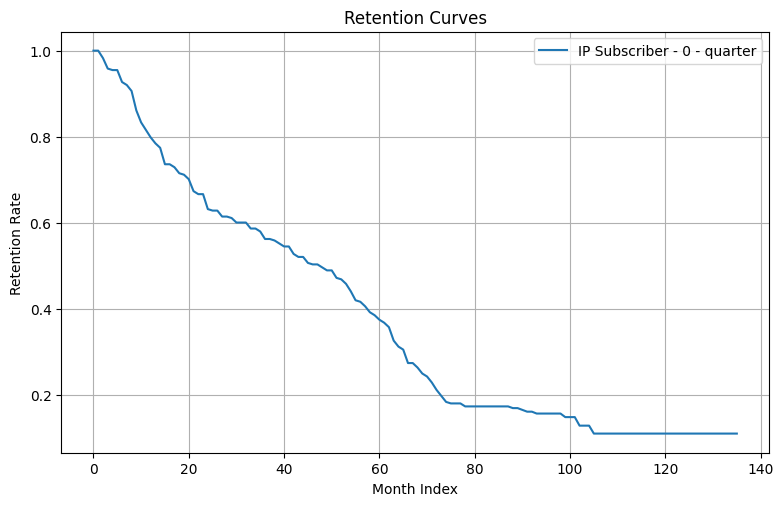

{'package_type': 'IP Subscriber', 'trial_duration_months': 3, 'term_cadence': 'year'}


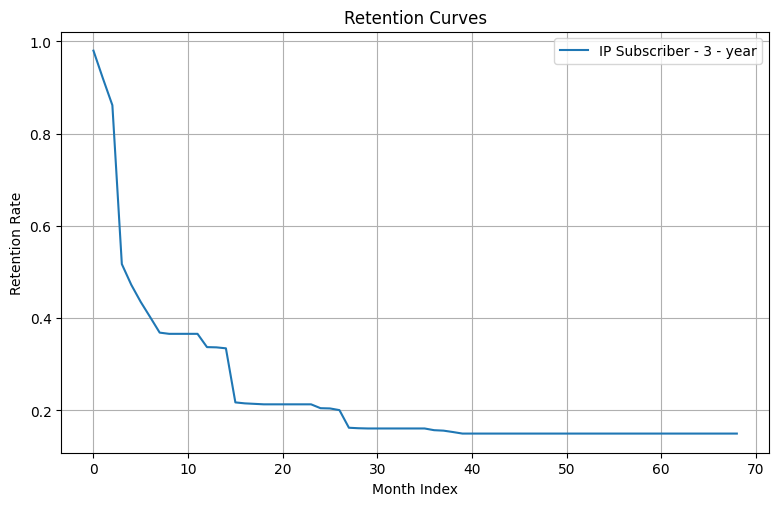

{'package_type': 'Recurring Donation', 'trial_duration_months': 0, 'term_cadence': 'month'}


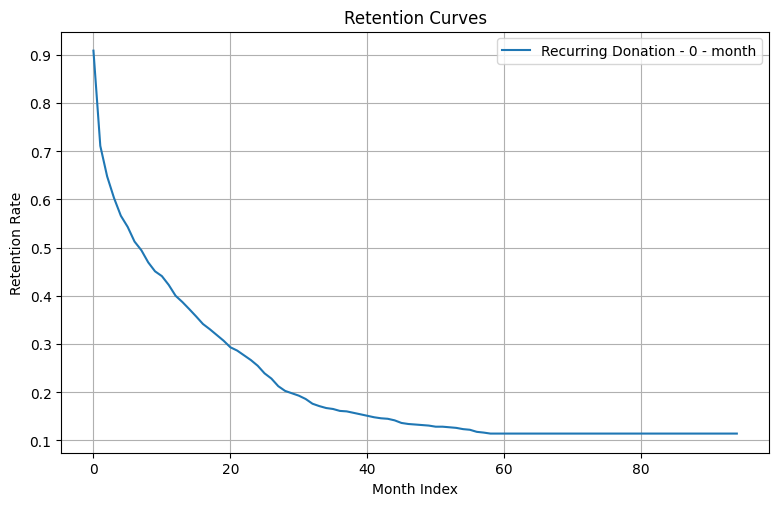

{'package_type': 'Student Subscription', 'trial_duration_months': 1, 'term_cadence': 'year'}


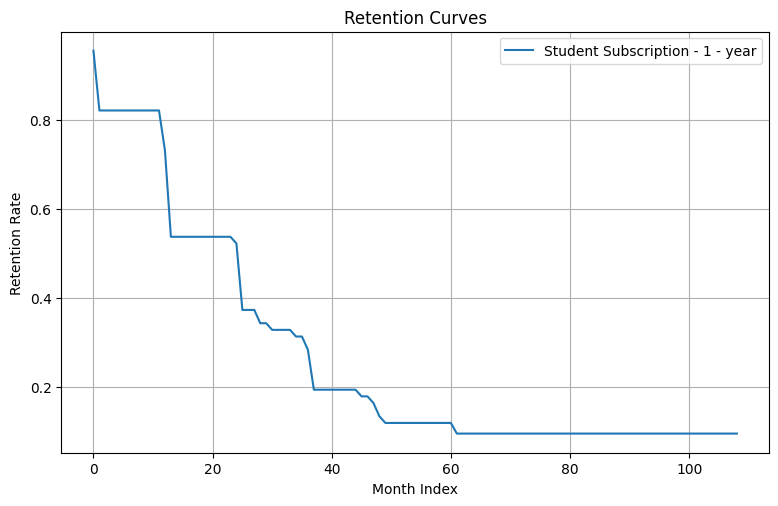

{'package_type': 'IP Subscriber', 'trial_duration_months': 0, 'term_cadence': 'quarter'}


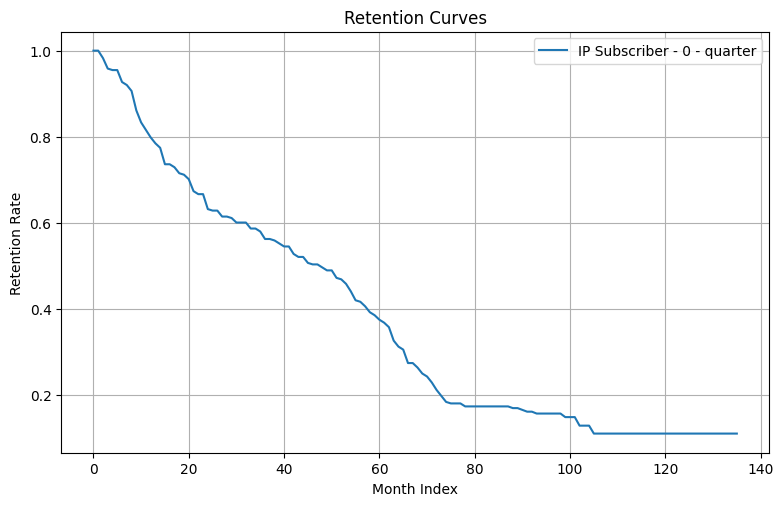

{'package_type': 'DIGITAL Subscriber', 'trial_duration_months': 0, 'term_cadence': 'month'}


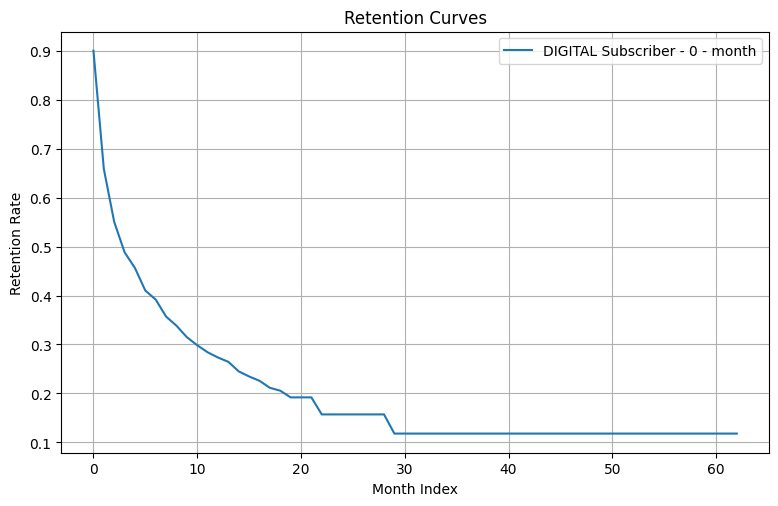

{'package_type': 'TIDE Subscriber', 'trial_duration_months': 0, 'term_cadence': 'month'}


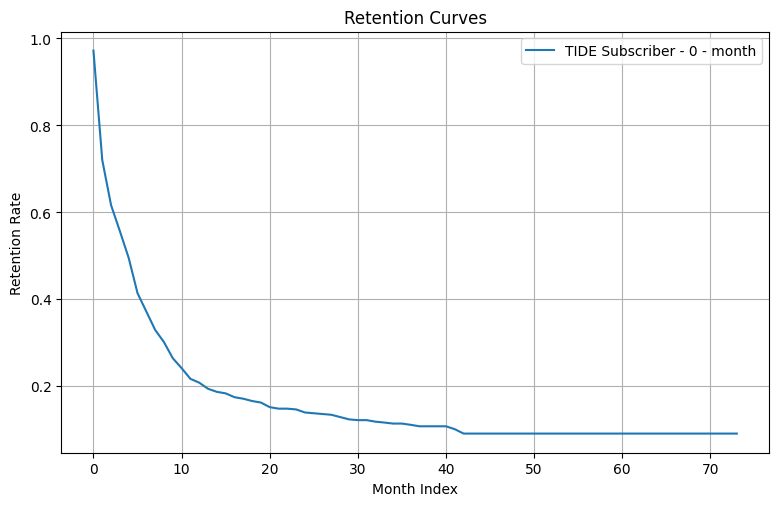

{'package_type': 'IP Subscriber', 'trial_duration_months': 0, 'term_cadence': 'month'}


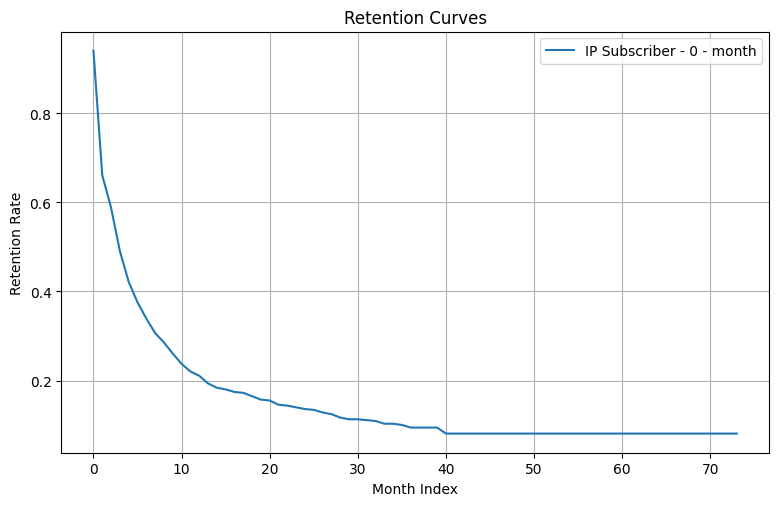

{'package_type': 'IP Subscriber', 'trial_duration_months': 3, 'term_cadence': 'year'}


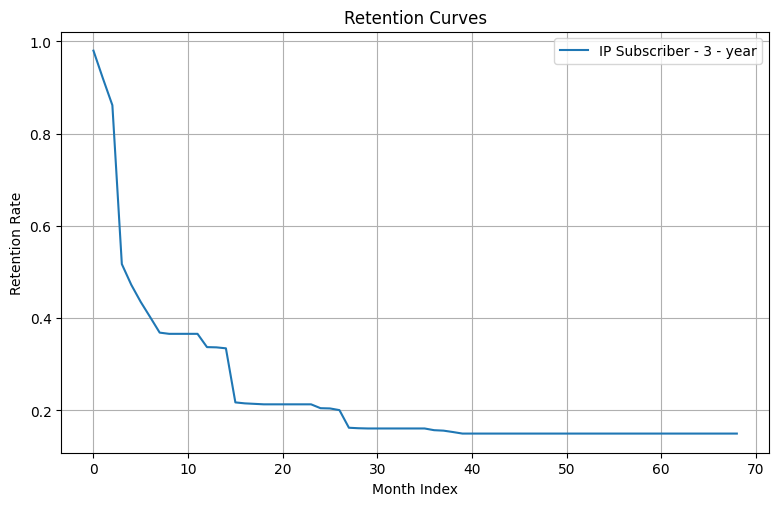

{'package_type': 'TIDE Subscriber', 'trial_duration_months': 1, 'term_cadence': 'year'}


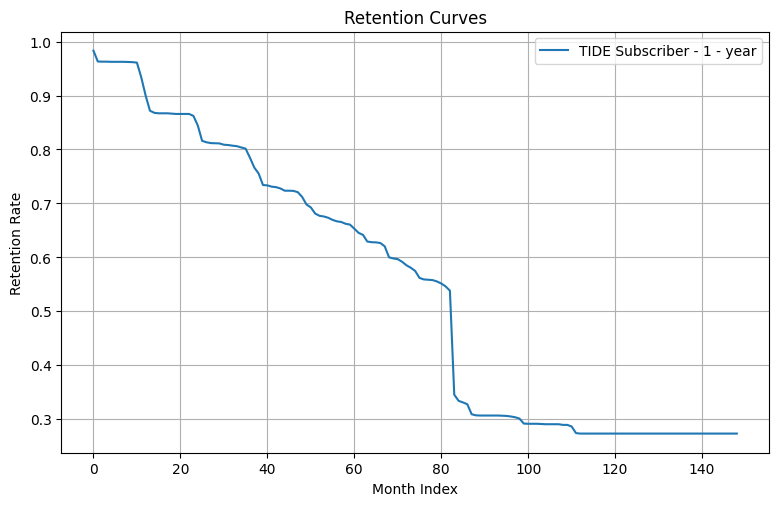

{'package_type': 'IP Subscriber', 'trial_duration_months': 0, 'term_cadence': 'quarter'}


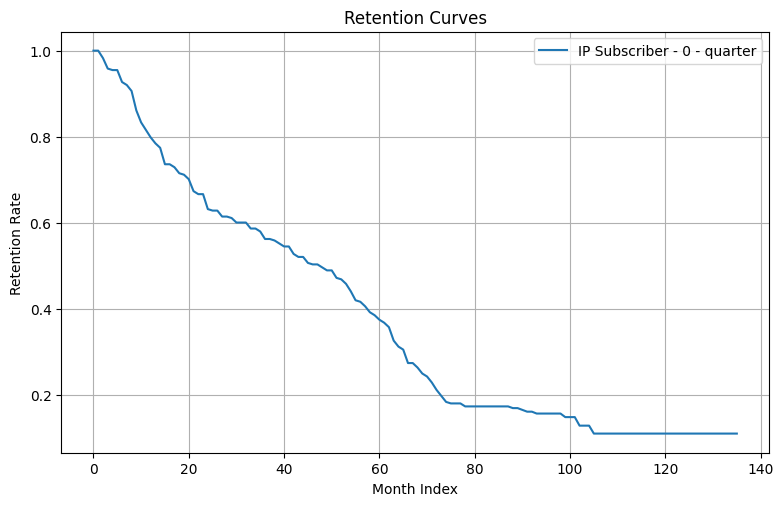

{'package_type': 'IP Subscriber', 'trial_duration_months': 1, 'term_cadence': 'month'}


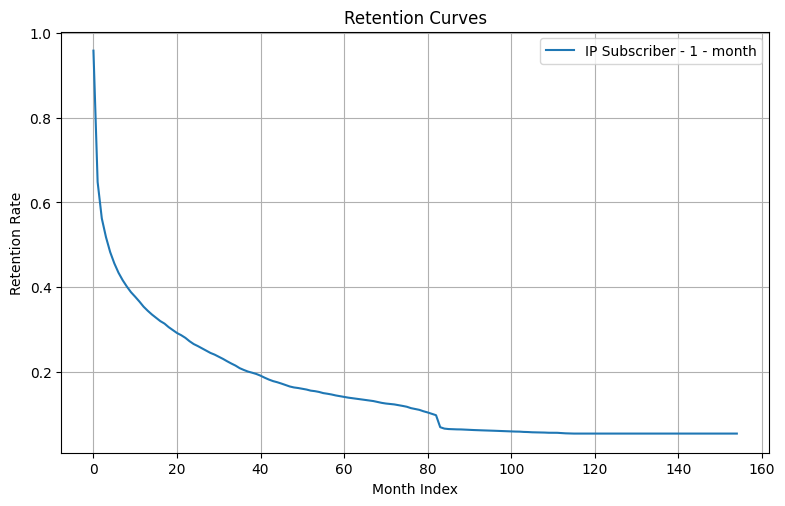

{'package_type': 'DIGITAL Subscriber', 'trial_duration_months': 6, 'term_cadence': 'year'}


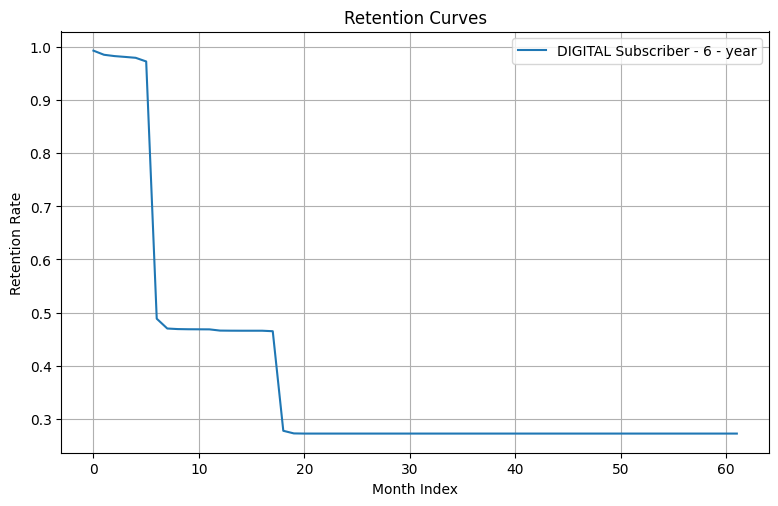

{'package_type': 'TIDE Subscriber', 'trial_duration_months': 6, 'term_cadence': 'year'}


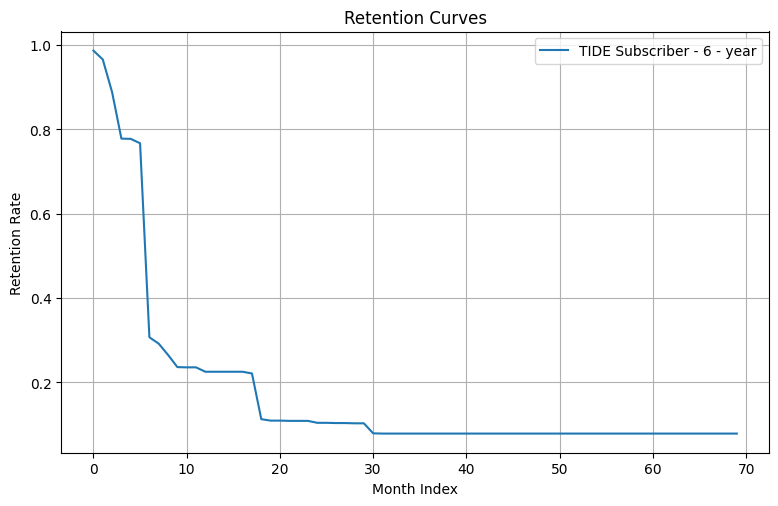

{'package_type': 'Student Subscription', 'trial_duration_months': 3, 'term_cadence': 'month'}


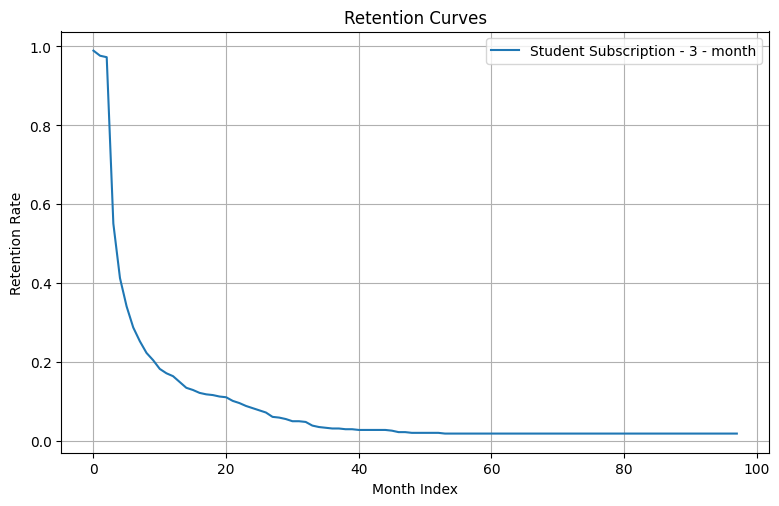

In [ ]:
def plot_km(**kwargs):

    if set(kwargs.keys()) != set(splits):
        raise ValueError(f"Invalid filter keys: {list(kwargs.keys())}. Keys must be: {splits}")

    subset_df = retention_curves.copy()

    for col, value in kwargs.items():
        subset_df = subset_df[subset_df[col] == value]

    label = " - ".join(str(v) for v in kwargs.values())

    plt.plot(
        subset_df["month_index"],
        subset_df["retention_curve_rate"],
        linestyle="-",
        label=label,
    )

for i in range(15):

    random_row = retention_curves[splits].sample(1).iloc[0]
    random_splits = random_row.to_dict()

    print(random_splits)

    plt.figure(figsize=(8, 5))
    plt.xlabel("Month Index")
    plt.ylabel("Retention Rate")
    plt.grid(True)
    plt.tight_layout()

    plt.title("Retention Curves")

    plot_km(
        **random_splits
    )

    plt.legend()
    plt.show()

# User Bases

In [ ]:
base_splits = splits + ["trial_price_value","trial_price","term_price", "term_price_value", "payment_currency", "region","signup_cohort", "trial_duration"]
base_splits_str = ", ".join(base_splits)

start_date = '2015-01-01'
latest_date = '2025-09-01'
forecast_to_date = '2027-12-01'

# Based on 6-month average (March-July 2025)
payment_failure_loss_rate = 0.8

query = f"""
WITH
# Creating calendar dates to fill in missing months + add future months
  calendar AS (
    SELECT calendar_month
    FROM UNNEST(GENERATE_DATE_ARRAY('{start_date}', '{forecast_to_date}', INTERVAL 1 MONTH)) AS calendar_month
  ),

  subs_details AS (
  SELECT
# Base splits are all the different cohorts in our user base: This includes the retention curves splits and the sign up cohorts
    {base_splits_str},

    calendar_month,
#  This pulls expiration date back 28 days for (potential) payment failures as these individuals will not make any payments on their last 28 days (this makes forecasting revenue more accurate)
    DATE(
      DATE_TRUNC(
        CASE
          WHEN (LOWER(piano_status) LIKE 'payment failure') OR (LOWER(piano_status) LIKE 'active' AND subscription_grace_period_start_date IS NOT NULL AND RAND() < {payment_failure_loss_rate})
            THEN DATE_SUB(user_access_expiration_date, INTERVAL 28 DAY)
          ELSE
            user_access_expiration_date
        END
      , MONTH))
    AS expire_month,

    DATE(DATE_TRUNC(subscription_trial_end_date, MONTH)) AS trial_end_month,

  FROM
    `indy-eng.reader_revenue_dataform.subscription_details_snapshots_enhanced`
  JOIN
    calendar ON calendar.calendar_month >= DATE(DATE_TRUNC(start_date, MONTH))
# Membership is removed here as it is included in the final forecast doc
  WHERE
     customer_type NOT LIKE "Test"
  AND LOWER(package_type) NOT LIKE "%app%"
  AND customer_type NOT LIKE "Membership"
  AND start_date IS NOT NULL
  AND is_blacklisted IS FALSE
  AND run_date = "{subs_details_rundate}"
  )

SELECT

  {base_splits_str},

  calendar_month,
  DATE_DIFF(calendar_month, signup_cohort, month) AS month_index,

  SUM(
    CASE
        WHEN
            (calendar_month BETWEEN signup_cohort AND (expire_month - 1))
            # OR (expire_month IS NULL)
        THEN 1
    ELSE 0 END) AS active_users,

  MAX(COUNT(*)) OVER(PARTITION BY {base_splits_str}) as total_cohort_users

FROM
  subs_details
WHERE
  signup_cohort <= '{latest_date}'

GROUP BY
    ALL
ORDER BY
    signup_cohort, calendar_month
"""

query_job = client.query(query)
cohort_df = query_job.to_dataframe()

In [ ]:
# Filling in any empty entries w/ null values
cohort_df["trial_duration_months"].fillna(0, inplace=True)
cohort_df["trial_price_value"].fillna(0, inplace=True)

/tmp/ipython-input-3462576380.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cohort_df["trial_duration_months"].fillna(0, inplace=True)
/tmp/ipython-input-3462576380.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [ ]:
# Check for NA values
mask = cohort_df["calendar_month"] >= date(2025, 11, 1)
cohort_df.loc[mask, "active_users"] = 0

In [ ]:
cohort_df.isna().sum()

,0
package_type,0
trial_duration_months,0
term_cadence,0
trial_price_value,0
trial_price,0
term_price,0
term_price_value,0
payment_currency,0
region,0
signup_cohort,0


In [ ]:
# Checking historical base
mask = (cohort_df["calendar_month"] > date(2025,7,1))

cohort_df[mask].groupby(["calendar_month"])["active_users"].sum().reset_index()

,calendar_month,active_users
0,2025-08-01,34708
1,2025-09-01,34408
2,2025-10-01,29026
3,2025-11-01,0
4,2025-12-01,0
5,2026-01-01,0
6,2026-02-01,0
7,2026-03-01,0
8,2026-04-01,0
9,2026-05-01,0


# Acquisition


## Calculating Subscription Acquisitions (Based on PAVs)

In [ ]:
#  Introducing CVR of different acquisition sources
# Uploading GSheet with CVR (Ideally would pull this directly from Adobe/ GA4 but nature of conversion data complicates this)

import gspread
from google.auth import default

auth.authenticate_user()
creds, _ = default()

# Authorize gspread
gc = gspread.authorize(creds)

# Opening GSheet
sheet_url = 'https://docs.google.com/spreadsheets/d/14bVpG_hj_YrBmHdCTTfckKHAkBOAlVSMeKUgEyzZqSk/edit?usp=sharing'

acq_spreadsheet = gc.open_by_url(sheet_url)

conversions_by_source = acq_spreadsheet.sheet1


# Use get_worksheet on the spreadsheet object to get the second worksheet (index 1)
cvr_by_source = acq_spreadsheet.get_worksheet(1)

#  Turning into dataframes
conv_by_source_df = pd.DataFrame(conversions_by_source.get_all_records())
cvr_by_source_df = pd.DataFrame(cvr_by_source.get_all_records())

In [ ]:
# Introducing Emily's traffic assumptions


sheet_url = 'https://docs.google.com/spreadsheets/d/1u1luHB9rRBj9ih0x9e2kBF2CA9Dj8RjRaSkvf1jZc9Q/edit?usp=sharing'

traffic_forecast = gc.open_by_url(sheet_url)

# Note: Only UK+ROW subscriptions will be tied to traffic, US traffic has been removed from the below
PAV_forecast_df = pd.DataFrame(traffic_forecast.get_worksheet(2).get_all_records())
PAV_forecast_df = PAV_forecast_df[pd.to_datetime(PAV_forecast_df['date']).dt.date> date(2025,12,1)]

HPPU_forecast_df = pd.DataFrame(traffic_forecast.get_worksheet(4).get_all_records())
HPPU_forecast_df = HPPU_forecast_df[pd.to_datetime(HPPU_forecast_df['date']).dt.date> date(2025,12,1)]

In [ ]:
#Defining subscription source
PAV_forecast_df['Subscription Experience']='Premium Article Gate'
HPPU_forecast_df['Subscription Experience']='HPPU / Section PU'

# NOTE: This adds all traffic UK+ROW into UK region - change if possible
PAV_forecast_df['region']='UK'
HPPU_forecast_df['region']='UK'

# Merging CVR into traffic Forecasts
PAV_forecast_df = pd.merge(PAV_forecast_df, cvr_by_source_df[['Subscription Experience', 'CVR']], on='Subscription Experience', how='left')
HPPU_forecast_df = pd.merge(HPPU_forecast_df, cvr_by_source_df[['Subscription Experience', 'CVR']], on='Subscription Experience', how='left')

In [ ]:
# Calculate new subscribers from PAV forecasts
PAV_forecast_df['New Subscribers'] = PAV_forecast_df['PAVs'] * PAV_forecast_df['CVR'].str.rstrip('%').astype('float') / 100.0

# Calculate new subscribers from HPPU forecasts
HPPU_forecast_df['New Subscribers'] = HPPU_forecast_df['UK_PVs'] * HPPU_forecast_df['CVR'].str.rstrip('%').astype('float') / 100.0

print("PAV Forecast:")
display(PAV_forecast_df.head())


print("\nHPPU Forecast:")
display(HPPU_forecast_df.head())


PAV Forecast:


,date,PAVs,Subscription Experience,region,CVR,New Subscribers
0,2026-01-01,2968219,Premium Article Gate,UK,0.020%,593.6438
1,2026-02-01,2687016,Premium Article Gate,UK,0.020%,537.4032
2,2026-03-01,2974077,Premium Article Gate,UK,0.020%,594.8154
3,2026-04-01,2870577,Premium Article Gate,UK,0.020%,574.1154
4,2026-05-01,2956502,Premium Article Gate,UK,0.020%,591.3004



HPPU Forecast:


,date,UK_PVs,Subscription Experience,region,CVR,New Subscribers
0,2026-01-01,20461536,HPPU / Section PU,UK,0.004%,818.46144
1,2026-02-01,18614569,HPPU / Section PU,UK,0.004%,744.58276
2,2026-03-01,20527174,HPPU / Section PU,UK,0.004%,821.08696
3,2026-04-01,19820216,HPPU / Section PU,UK,0.004%,792.80864
4,2026-05-01,20384576,HPPU / Section PU,UK,0.004%,815.38304


In [ ]:
# Grouping HPPU and PAG acquisitions together
forecasted_cohorts = pd.concat([
    PAV_forecast_df[['date', 'New Subscribers','Subscription Experience']],
    HPPU_forecast_df[['date', 'New Subscribers','Subscription Experience']],
], ignore_index=True)

# Introducing remaining subscription cohorts
sources = ['Navigation', 'Direct']
months_2026 = pd.date_range(start='2026-01-01', end='2026-12-01', freq='MS')

new_data = []
for source in sources:
    for month in months_2026:
        new_data.append({
            'date': month,
            'New Subscribers': 0,
            'Subscription Experience': source
        })

new_sources_df = pd.DataFrame(new_data)

forecasted_cohorts = pd.concat([forecasted_cohorts, new_sources_df], ignore_index=True)
forecasted_cohorts.date = pd.to_datetime(forecasted_cohorts.date).dt.date

#  Adding % of conversions from each sub journey

forecasted_cohorts = forecasted_cohorts.merge(conv_by_source_df[['Subscription Experience', '%']], on='Subscription Experience', how='left')

In [ ]:
# Calculate number of acquisitions for Navigation and Direct based on remaining acquisition %
forecasted_navigation=forecasted_cohorts.loc[forecasted_cohorts['Subscription Experience'] == 'Navigation', 'New Subscribers'] = (
    forecasted_cohorts[forecasted_cohorts['Subscription Experience'] == 'Premium Article Gate']['New Subscribers'].values[0] *
    forecasted_cohorts[forecasted_cohorts['Subscription Experience'] == 'Navigation']['%'].str.rstrip('%').astype('float') / 100.0 /
    forecasted_cohorts[forecasted_cohorts['Subscription Experience'] == 'Premium Article Gate']['%'].str.rstrip('%').astype('float') * 100.0
)

In [ ]:

PAG_metrics = forecasted_cohorts[forecasted_cohorts['Subscription Experience'] == 'Premium Article Gate'][['date', 'New Subscribers', '%']].copy().rename(columns={'%': 'PAG_%', 'New Subscribers': 'PAG_New_Subscribers'})
forecasted_cohorts = forecasted_cohorts.merge(PAG_metrics, on='date', how='left')

#  Calculating new acquisitions from Navigation
forecasted_cohorts.loc[forecasted_cohorts['Subscription Experience'] == 'Navigation', 'New Subscribers'] = (
    forecasted_cohorts['PAG_New_Subscribers'] *
    (forecasted_cohorts['%'].str.rstrip('%').astype('float') / 100.0 )/
    (forecasted_cohorts['PAG_%'].str.rstrip('%').astype('float') / 100.0)
)
#  Calculating new acquisitions from Direct
forecasted_cohorts.loc[forecasted_cohorts['Subscription Experience'] == 'Direct', 'New Subscribers'] = (
    forecasted_cohorts['PAG_New_Subscribers'] *
    (forecasted_cohorts['%'].str.rstrip('%').astype('float') / 100.0 )/
    (forecasted_cohorts['PAG_%'].str.rstrip('%').astype('float') / 100.0)
    )


In [ ]:
forecasted_subs = forecasted_cohorts.groupby('date')['New Subscribers'].sum()

In [ ]:
forecasted_subs = pd.DataFrame(forecasted_subs).reset_index()
forecasted_subs['date'] = forecasted_subs['date'].astype(str)

In [ ]:
forecasted_subs.head()

,date,New Subscribers
0,2026-01-01,1846.223614
1,2026-02-01,1674.976846
2,2026-03-01,1850.877498
3,2026-04-01,1786.761733
4,2026-05-01,1839.088138


### Introduce Indigital Acquisition Uplifts

In [ ]:
# Introducing Indigital Acquisition Uplifts


sheet_url = 'https://docs.google.com/spreadsheets/d/1nxQCG35lE99LpmX2OYRhbn7V26L9iZeVOIcxTy0HlgI/edit?usp=sharing'

indigital_uplift = gc.open_by_url(sheet_url)

indigital_uplift_df= pd.DataFrame(indigital_uplift.get_worksheet(0).get_all_records())
# Ensure date is the same data type as forecasted_subs
indigital_uplift_df['date'] = indigital_uplift_df['date'].astype(str)

In [ ]:
indigital_uplift_df.head(1)

,New Subscribers,date
0,0,2026-01-01


In [ ]:
# Adding indigital uplift to expected subscribers

forecasted_subs = pd.concat([forecasted_subs,indigital_uplift_df]).reset_index(drop=True)
forecasted_subs = forecasted_subs.groupby('date')['New Subscribers'].sum().reset_index()

In [ ]:
forecasted_subs

,date,New Subscribers
0,2026-01-01,1846.223614
1,2026-02-01,1674.976846
2,2026-03-01,1850.877498
3,2026-04-01,1786.761733
4,2026-05-01,1839.088138
5,2026-06-01,3359.042702
6,2026-07-01,3156.658197
7,2026-08-01,3137.654810
8,2026-09-01,3088.898022
9,2026-10-01,3144.790938


In [ ]:
six_months_ago = (pd.Timestamp.now() - pd.DateOffset(months=6)).replace(day=1).date()
current_users_breakdown = cohort_df[((
    (cohort_df['package_type'].isin(['DIGITAL Subscriber']))
&   (cohort_df['term_cadence'].isin(['month', 'year']))
&   (cohort_df['term_price'].isin(['GBP11.00','EUR11.00', 'GBP99.00','EUR99.00', 'GBP4.00', 'EUR4.00']))
& (cohort_df['trial_price'].isin(['GBP1.00','EUR1.00']))
& (cohort_df['trial_duration'].isin(['6 month']))
 | (
     (cohort_df['package_type'].isin(['Consent Or Pay Only Subscriber','Student Subscription']))
&   (cohort_df['term_cadence'].isin(['month']))
&   (cohort_df['term_price'].isin(['GBP4.00','EUR4.00', 'GBP1.00','EUR1.00']))
& (cohort_df['trial_price'].isin(['No trial']))
))
& (cohort_df['signup_cohort'] >= six_months_ago)
& (cohort_df['month_index'] == 0))

]

In [ ]:
current_users_breakdown = current_users_breakdown.groupby(['region', 'package_type','trial_duration', 'term_cadence','trial_price','term_price','month_index'])['total_cohort_users'].sum().reset_index()
current_users_breakdown['all_in_cohort'] = current_users_breakdown['total_cohort_users'].sum()

In [ ]:
current_users_breakdown['perc_subs'] = current_users_breakdown['total_cohort_users'] / current_users_breakdown['all_in_cohort']

In [ ]:
combined = forecasted_subs.merge(current_users_breakdown[['region', 'package_type', 'term_cadence', 'trial_duration', 'trial_price', 'term_price', 'month_index','perc_subs']], how='cross')

In [ ]:
combined['forecasted_subs'] = combined['New Subscribers'] * combined['perc_subs']

In [ ]:
# Manually fixing erroneous term

broken_term = (
    (combined["region"] == "EUR")
    & (combined["term_cadence"] == "month")
    & (combined["term_price"] == "EUR99.00")
)
combined.loc[broken_term, 'forecasted_subs'] = 0

In [ ]:
combined[broken_term]

,date,New Subscribers,region,package_type,term_cadence,trial_duration,trial_price,term_price,month_index,perc_subs,forecasted_subs
1,2026-01-01,1846.223614,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
8,2026-02-01,1674.976846,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
15,2026-03-01,1850.877498,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
22,2026-04-01,1786.761733,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
29,2026-05-01,1839.088138,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
36,2026-06-01,3359.042702,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
43,2026-07-01,3156.658197,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
50,2026-08-01,3137.654810,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
57,2026-09-01,3088.898022,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0
64,2026-10-01,3144.790938,EUR,DIGITAL Subscriber,month,6 month,EUR1.00,EUR99.00,0,0.000117,0.0


## Calculating recurring donation acquisition, students and COP (Based on 6-month average)

In [ ]:
acq_forecast_cohort_df =cohort_df[cohort_df['calendar_month'] < date(2025,10,1)].copy()

#  Adding unique keys for retention curve splits and cohort splits
retention_curve_splits = [split for split in splits if split != "trial_duration_months"]
added_splits = [
        'region', 'term_price', 'trial_price', 'trial_duration'
    ]



acq_forecast_cohort_df['retention_curve_splits'] = acq_forecast_cohort_df[retention_curve_splits].apply(lambda row: ','.join(row.values.astype(str)), axis=1)
acq_forecast_cohort_df['cohort_splits'] = acq_forecast_cohort_df[retention_curve_splits + added_splits].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

In [ ]:
# Introducing new cohorts that will be acquired in 2026
def generate_new_cohorts(cohorts_df, forecast_months=27):
    cohorts_df = cohorts_df.copy()
    cohorts_df['calendar_month'] = pd.PeriodIndex(cohorts_df['calendar_month'], freq='M')


    acq_weights = np.array([0.083, 0.083, 0.084, 0.25, 0.25, 0.25])
    acq_weights = acq_weights / acq_weights.sum()

    future_cohorts = []

    for month_ahead in range(1, forecast_months + 1):
        last_calendar = cohorts_df['calendar_month'].max()  # global last month

        new_month = last_calendar + 1  # next calendar month

        # Process each cohort_split separately
        for cohort_splits, group in cohorts_df[cohorts_df['month_index'] == 0].groupby('cohort_splits'):

            full_range = pd.period_range(
                start=group['calendar_month'].min(),
                end=last_calendar,
                freq='M'
            )

            group = (
                group.set_index('calendar_month')
                     .reindex(full_range)
                     .rename_axis('calendar_month')
                     .reset_index()
            )
            group['total_cohort_users'] = group['total_cohort_users'].fillna(0)
            group['active_users'] = group['active_users'].fillna(0)
            for col in splits + added_splits:
                if col in group.columns:
                    group[col] = group[col].ffill().bfill()

            recent = group.sort_values('calendar_month').tail(6)
            # As some terms have been removed in Aug 2025, I have shortened length of months until we consider a term expired to 2
            is_term_active = group.sort_values('calendar_month').tail(2)
            if len(is_term_active) == 0:
                continue

            w = acq_weights[-len(recent):]
            avg_new_users = round(np.average(recent['total_cohort_users'], weights=w),0)

            new_cohort = {
                'signup_cohort': new_month,
                'calendar_month': new_month,
                'month_index': 0,
                'total_cohort_users': avg_new_users,
                'active_users': avg_new_users,
                'cohort_splits': cohort_splits
            }

            future_cohorts.append(new_cohort)

            # Append immediately so next iteration uses this new cohort
            cohorts_df = pd.concat([cohorts_df, pd.DataFrame([new_cohort])], ignore_index=True)

    return pd.DataFrame(future_cohorts)

future_cohorts = generate_new_cohorts(acq_forecast_cohort_df.copy()).sort_values(['cohort_splits','signup_cohort','calendar_month'])



In [ ]:
future_cohorts[['package_type', 'term_cadence','region', 'term_price', 'trial_price', 'trial_duration']] = future_cohorts['cohort_splits'].str.split(',', expand=True)
future_cohorts['retention_curve_splits'] = future_cohorts[retention_curve_splits].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

future_cohorts['signup_cohort'] = future_cohorts['signup_cohort'].astype(str) + '-01'

future_cohorts['calendar_month'] = future_cohorts['calendar_month'].astype(str)+ '-01'


#  Set all future cohorts to be non-trialists except current monthly and current annual
future_cohorts['trial_status']='non-trialist'

In [ ]:
active_subs_terms =  (
    (future_cohorts['package_type']== 'DIGITAL Subscriber')
    & (future_cohorts['term_cadence'].isin(['month', 'year']))
    & (future_cohorts['term_price'].isin(['GBP11.00','EUR11.00', 'GBP99.00', 'EUR99.00']))
    & (future_cohorts['trial_price'].isin(['GBP1.00','EUR1.00']))
    & (future_cohorts['trial_duration']=='6 month')
)

future_cohorts.loc[active_subs_terms, 'trial_status'] = 'trialist'

In [ ]:
future_cohorts[future_cohorts['trial_status'] == 'trialist']['cohort_splits'].unique()

array(['DIGITAL Subscriber,month,EUR,EUR11.00,EUR1.00,6 month',
       'DIGITAL Subscriber,month,EUR,EUR99.00,EUR1.00,6 month',
       'DIGITAL Subscriber,month,UK,GBP11.00,GBP1.00,6 month',
       'DIGITAL Subscriber,year,EUR,EUR99.00,EUR1.00,6 month',
       'DIGITAL Subscriber,year,UK,GBP99.00,GBP1.00,6 month'],
      dtype=object)

## Combining both methodologies (prioritising PAV methodology for subs)


In [ ]:
future_cohorts[future_cohorts['trial_status'] == 'trialist'].head(1)

,signup_cohort,calendar_month,month_index,total_cohort_users,active_users,cohort_splits,package_type,term_cadence,region,term_price,trial_price,trial_duration,retention_curve_splits,trial_status
2,2025-10-01,2025-10-01,0,53.0,53.0,"DIGITAL Subscriber,month,EUR,EUR11.00,EUR1.00,...",DIGITAL Subscriber,month,EUR,EUR11.00,EUR1.00,6 month,"DIGITAL Subscriber,month",trialist


In [ ]:
final_forecasted_subs = combined[['date', 'region', 'package_type', 'term_cadence', 'trial_duration', 'trial_price', 'term_price', 'month_index', 'forecasted_subs']]
final_forecasted_subs['cohort_splits'] = final_forecasted_subs[retention_curve_splits + added_splits].apply(lambda row: ','.join(row.values.astype(str)), axis=1)

/tmp/ipython-input-4021251213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecasted_subs['cohort_splits'] = final_forecasted_subs[retention_curve_splits + added_splits].apply(lambda row: ','.join(row.values.astype(str)), axis=1)


In [ ]:
# Ensure key columns are same type
future_cohorts['cohort_splits'] = future_cohorts['cohort_splits'].astype(str)
final_forecasted_subs['cohort_splits'] = final_forecasted_subs['cohort_splits'].astype(str)

final_forecasted_subs['date'] = final_forecasted_subs['date'].astype(str)

merged = future_cohorts.merge(
    final_forecasted_subs[['date', 'cohort_splits', 'forecasted_subs']],
    left_on=['calendar_month', 'cohort_splits'],
    right_on=['date', 'cohort_splits'],
    how='left'
)

merged.loc[merged['forecasted_subs'].notna(), 'active_users'] = merged['forecasted_subs']
merged.loc[merged['forecasted_subs'].notna(), 'total_cohort_users'] = merged['forecasted_subs']

/tmp/ipython-input-3199863040.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecasted_subs['cohort_splits'] = final_forecasted_subs['cohort_splits'].astype(str)
/tmp/ipython-input-3199863040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_forecasted_subs['date'] = final_forecasted_subs['date'].astype(str)


In [ ]:
acquisition_df = merged.copy()

acquisition_df.drop(
    [
        'retention_curve_splits',
        'cohort_splits',
        'date',
        'forecasted_subs',
        'trial_status'
    ],
    axis=1,
    inplace=True
)

future_final_cohorts = acquisition_df[pd.to_datetime(acquisition_df["calendar_month"]).dt.date >= date(2025,10,1)]

In [ ]:
future_final_cohorts

,signup_cohort,calendar_month,month_index,total_cohort_users,active_users,package_type,term_cadence,region,term_price,trial_price,trial_duration
0,2025-10-01,2025-10-01,0,29.000000,29.000000,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial
1,2025-11-01,2025-11-01,0,29.000000,29.000000,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial
2,2025-12-01,2025-12-01,0,28.000000,28.000000,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial
3,2026-01-01,2026-01-01,0,39.157075,39.157075,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial
4,2026-02-01,2026-02-01,0,35.525054,35.525054,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial
...,...,...,...,...,...,...,...,...,...,...,...
5152,2027-08-01,2027-08-01,0,0.000000,0.000000,TIDE Subscriber,year,US,$99.00,$6.00,6 month
5153,2027-09-01,2027-09-01,0,0.000000,0.000000,TIDE Subscriber,year,US,$99.00,$6.00,6 month
5154,2027-10-01,2027-10-01,0,0.000000,0.000000,TIDE Subscriber,year,US,$99.00,$6.00,6 month
5155,2027-11-01,2027-11-01,0,0.000000,0.000000,TIDE Subscriber,year,US,$99.00,$6.00,6 month


## Extending Acquisition

In [ ]:
forecast_date = date(2027,12,1)

extend_aquisition_splits = ["signup_cohort", "package_type", "term_cadence", "region", "term_price", "trial_price", "trial_duration", "total_cohort_users"]

def extend_aquisition_data(group):

    if len(group) > 1:
        raise Exception()

    start_month = group["calendar_month"].iloc[0]

    date_range = pd.date_range(start_month, forecast_date, freq="MS")

    group = group.set_index("calendar_month")
    group.index = pd.to_datetime(group.index)
    group = group.reindex(date_range)

    group['month_index'] = range(0, len(group))
    group['active_users'] = group['active_users'].fillna(0)

    group = group.reset_index().rename(columns={'index': 'calendar_month'})

    return group

extended_aquisition_data_extended = future_final_cohorts.groupby(extend_aquisition_splits).apply(extend_aquisition_data, include_groups=False).reset_index()

In [ ]:
extended_aquisition_data_extended["trial_price_value"] = extended_aquisition_data_extended["trial_price"].str.extract(r'(\d+\.?\d*)')[0].astype(float).fillna(0)
extended_aquisition_data_extended["term_price_value"] = extended_aquisition_data_extended["term_price"].str.extract(r'(\d+\.?\d*)')[0].astype(float).fillna(0)

In [ ]:
# Recreate the broken_term boolean Series using extended_aquisition_data_extended
broken_term_extended = (
    (extended_aquisition_data_extended["region"] == "EUR")
    & (extended_aquisition_data_extended["term_cadence"] == "month")
    & (extended_aquisition_data_extended["term_price"] == "EUR99.00")
)

extended_aquisition_data_extended.loc[broken_term_extended, 'active_users'] = 0
extended_aquisition_data_extended.loc[broken_term_extended, 'total_cohort_users'] = 0

# Merging User Base & Aquisition

In [ ]:
for col in ["active_users", "total_cohort_users"]:
    cohort_df[col] = pd.to_numeric(cohort_df[col], errors="coerce").astype("Int64")
    extended_aquisition_data_extended[col] = (
        pd.to_numeric(extended_aquisition_data_extended[col], errors="coerce").round().astype("Int64")
    )

for col in ["calendar_month", "signup_cohort"]:
    cohort_df[col] = pd.to_datetime(cohort_df[col], errors="coerce").dt.date
    extended_aquisition_data_extended[col] = pd.to_datetime(extended_aquisition_data_extended[col], errors="coerce").dt.date

In [ ]:
extended_aquisition_data_extended["trial_duration_months"] = extended_aquisition_data_extended["trial_duration"].map(cadence_map)

In [ ]:
extended_aquisition_data_extended

,signup_cohort,package_type,term_cadence,region,term_price,trial_price,trial_duration,total_cohort_users,level_8,calendar_month,month_index,active_users,trial_price_value,term_price_value,trial_duration_months
0,2025-10-01,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial,29,0,2025-10-01,0,29,0.00,4.00,0
1,2025-10-01,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial,29,1,2025-11-01,1,0,0.00,4.00,0
2,2025-10-01,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial,29,2,2025-12-01,2,0,0.00,4.00,0
3,2025-10-01,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial,29,3,2026-01-01,3,0,0.00,4.00,0
4,2025-10-01,Consent Or Pay Only Subscriber,month,UK,GBP4.00,No trial,No trial,29,4,2026-02-01,4,0,0.00,4.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72193,2027-12-01,TIDE Subscriber,year,US,$179.99,$139.99,year,0,0,2027-12-01,0,0,139.99,179.99,12
72194,2027-12-01,TIDE Subscriber,year,US,$24.00,$24.00,year,0,0,2027-12-01,0,0,24.00,24.00,12
72195,2027-12-01,TIDE Subscriber,year,US,$24.00,No trial,No trial,0,0,2027-12-01,0,0,0.00,24.00,0
72196,2027-12-01,TIDE Subscriber,year,US,$82.99,$3.00,quarter,0,0,2027-12-01,0,0,3.00,82.99,3


In [ ]:
base_acq_df = pd.concat([cohort_df, extended_aquisition_data_extended], ignore_index=True)

In [ ]:
base_acq_df = base_acq_df.drop('level_8', axis="columns")

In [ ]:
currency_code_map = {
    "UK": "GBP",
    "EUR": "EUR",
    "US": "USD"
}

base_acq_df["payment_currency"] = base_acq_df["region"].map(currency_code_map)

# Applying Retention Curves

In [ ]:
base_acq_retcurves_df = base_acq_df.merge(retention_curves, how='left', on = splits + ["month_index"])

In [ ]:
base_acq_retcurves_df.piecewise_retention_rate = base_acq_retcurves_df.piecewise_retention_rate.fillna(1)

In [ ]:
base_acq_retcurves_df = base_acq_retcurves_df.sort_values(base_splits + ["month_index"])

base_acq_retcurves_df["previous_active_users"] = (
    base_acq_retcurves_df
    .groupby(base_splits, dropna=False)["active_users"]
    .shift(1)
)

def recursive_forecast(group):
    preds = []
    for i, row in group.iterrows():

        # If row is an actual value, keep prediction to be active users
        if row["calendar_month"] <= date(2025,9,1):
            preds.append(row["active_users"])

        elif not preds and row["active_users"] != 0:
            preds.append(row["active_users"])

        elif not preds and row["active_users"] == 0:
            preds.append(0)

        # If a forecast value, multiply the previous predicted value by the piecewise retention rate
        else:
            prev_value = preds[-1] if preds else np.nan
            preds.append(prev_value * row["piecewise_retention_rate"] if pd.notna(prev_value) else np.nan)

    group["predicted_active_users"] = preds

    return group

base_acq_retcurves_forecast_df = base_acq_retcurves_df.groupby(base_splits, group_keys=False, dropna=False).apply(recursive_forecast)

# base_acq_retcurves_forecast_df["is_trialist"] = np.where(
#     base_acq_retcurves_forecast_df["trial_duration_months"] >= base_acq_retcurves_forecast_df["month_index"],
#         True,
#         False
# )

/tmp/ipython-input-1538198320.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  base_acq_retcurves_forecast_df = base_acq_retcurves_df.groupby(base_splits, group_keys=False, dropna=False).apply(recursive_forecast)


In [ ]:
base_acq_retcurves_forecast_df["is_trialist"] = np.where(
    (
        (base_acq_retcurves_forecast_df["trial_duration_months"] == 0)
        | (base_acq_retcurves_forecast_df["trial_duration_months"] <= (base_acq_retcurves_forecast_df["month_index"]))
    ),
    False,
    True
)


In [ ]:
mask = (base_acq_retcurves_forecast_df["calendar_month"] > date(2025,7,1))
acq = ((base_acq_retcurves_forecast_df["month_index"] == 0) & (base_acq_retcurves_forecast_df["calendar_month"] > date(2025,12,1)))
base_acq_retcurves_forecast_df[acq].groupby(["calendar_month"])["predicted_active_users"].sum().reset_index()

,calendar_month,predicted_active_users
0,2026-01-01,2058.0
1,2026-02-01,1850.0
2,2026-03-01,2035.0
3,2026-04-01,1979.0
4,2026-05-01,2026.0
5,2026-06-01,3547.0
6,2026-07-01,3345.0
7,2026-08-01,3325.0
8,2026-09-01,3278.0
9,2026-10-01,3335.0


In [ ]:
base_acq_retcurves_forecast_df[
    (base_acq_retcurves_forecast_df['package_type'] == 'DIGITAL Subscriber') &
    (base_acq_retcurves_forecast_df['trial_duration_months'] == 6) &
    (base_acq_retcurves_forecast_df['term_cadence'] == "year") &
    (base_acq_retcurves_forecast_df['region'] == 'UK') &
    (base_acq_retcurves_forecast_df['signup_cohort'] == date(2025,3,1))
]

,package_type,trial_duration_months,term_cadence,trial_price_value,trial_price,term_price,term_price_value,payment_currency,region,signup_cohort,trial_duration,calendar_month,month_index,active_users,total_cohort_users,retention_curve_rate,piecewise_retention_rate,previous_active_users,predicted_active_users,is_trialist
129179,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-03-01,0,1078,1252,0.992470,1.000000,<NA>,1078.000000,True
129196,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-04-01,1,1078,1252,0.984716,0.992187,1078,1078.000000,True
129213,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-05-01,2,1078,1252,0.982228,0.997473,1078,1078.000000,True
129230,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-06-01,3,1078,1252,0.980670,0.998414,1078,1078.000000,True
129247,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-07-01,4,1078,1252,0.979018,0.998316,1078,1078.000000,True
129264,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-08-01,5,1073,1252,0.972131,0.992965,1078,1073.000000,True
129281,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-09-01,6,401,1252,0.488531,0.502536,1073,401.000000,False
129298,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-10-01,7,384,1252,0.470042,0.962154,401,385.823872,False
129315,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-11-01,8,0,1252,0.468971,0.997721,384,384.944668,False
129332,DIGITAL Subscriber,6,year,1,GBP1.00,GBP99.00,99,GBP,UK,2025-03-01,6 month,2025-12-01,9,0,1252,0.468644,0.999302,0,384.675986,False


# Currency Conversions

In [ ]:
query = f"""
  SELECT
    Date,
    Currency_Code,
    MAX(GBP_Conversion) AS GBP_Conversion
  FROM `indy-eng.partners.currency_matchtable`
  WHERE
    date <= "{subs_details_rundate}"
  GROUP BY ALL
"""

query_job = client.query(query)
currency_conversion_df = query_job.to_dataframe()
currency_conversion_df["Date"] = pd.to_datetime(currency_conversion_df["Date"]).dt.date

## Fill Conversions

In [ ]:
min_date = date(2025,1,1)
max_date = date(2027,12,31)

date_range = pd.date_range(min_date, max_date, name="Date")

def ffill_currency_conversion(group):

    group = group.sort_values("Date", ascending=True)
    group = group.set_index("Date")
    group = group.reindex(date_range)
    group = group["GBP_Conversion"].ffill()
    group = group.reset_index()

    return group

currency_conversion_extended_df = currency_conversion_df.groupby(["Currency_Code"], group_keys=True).apply(ffill_currency_conversion,include_groups=True).reset_index().drop(["level_1"], axis="columns")
currency_conversion_extended_df["Date"] = pd.to_datetime(currency_conversion_extended_df["Date"]).dt.date

/tmp/ipython-input-2457843397.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  currency_conversion_extended_df = currency_conversion_df.groupby(["Currency_Code"], group_keys=True).apply(ffill_currency_conversion,include_groups=True).reset_index().drop(["level_1"], axis="columns")


# Offers

In [ ]:
query = f"""
WITH
clean_transactions_df AS (
  SELECT DISTINCT
    DATE(Date) AS transaction_date,
    DATE(TIMESTAMP_TRUNC(Date, MONTH)) AS yearmonth,
    piano_uid,
    tax_type,
    transaction_status,
    term_name,
    term_id,
    subscription_id,
    local_price,
    term_price_value,
    trial_price_value,
    expires,
    tax,
    tax_base,
    tax_rate,
    tax_country,
    term_cadence,
    region,
    package_type,
    customer_type,
    term_price,
    trial_duration,
  FROM
    `indy-eng.reader_revenue_dataform.transactions_log_enhanced`
  WHERE
    customer_type NOT LIKE "Test"
    AND DATE <= "{subs_details_rundate}"
  ),
-- Step 3: Net out refunds from payments to obtain what each uid payed per month
monthly_amount_paid AS (
  SELECT
    transaction_date,
    DATE_TRUNC(transaction_date, MONTH) AS transaction_month,
    piano_uid,
    term_id,
    subscription_id,
    trial_price_value,
    term_price_value,
    term_cadence,
    region,
    package_type,
    customer_type,
    ROUND(SUM(local_price),2) AS monthly_amount_paid
  FROM
    clean_transactions_df
  GROUP BY
    ALL
  ORDER BY
    monthly_amount_paid DESC, piano_uid
  ),
-- Step 4: Join transaction data with subscription_details
subs_details_needed AS (
  SELECT
    piano_uid,
    term_id,
    term_name,
    subscription_id,
    start_date,
    piano_status,
    user_access_expiration_date,
    subscription_trial_end_date
  FROM `indy-eng.reader_revenue_dataform.subscription_details_snapshots_enhanced`

  WHERE
    NOT REGEXP_CONTAINS(LOWER(term_name), r'(app | google | apple)') # As there is no transaction data for app subscriptions, I've removed it from subs
    AND run_date = "{subs_details_rundate}"
),
subs_and_trans AS (
  SELECT
    piano_uid,
    term_id,
    subscription_id,
    start_date,
    subscription_trial_end_date,
    user_access_expiration_date,
    transaction_month,
    term_cadence,
    region,
    package_type,
    customer_type,
    transaction_date,
    trial_price_value,
    term_price_value,
    CASE
      WHEN transaction_date < DATE(subscription_trial_end_date) THEN 'trialist'
      WHEN (transaction_date >= DATE(subscription_trial_end_date) OR subscription_trial_end_date IS NULL) THEN 'non_trialist'
      ELSE 'No tenure'
    END AS tenure,
    monthly_amount_paid
  FROM monthly_amount_paid AS mp
  LEFT JOIN subs_details_needed
  USING(
    piano_uid,
    term_id,
    subscription_id
    )
  ORDER BY
    piano_uid,
    term_id,
    subscription_id,
    transaction_month
)

  SELECT
    COUNT(subscription_id) AS number_of_offers,
    region,
    term_cadence,
    package_type,
    customer_type,
    transaction_month,
    monthly_amount_paid
  FROM
    subs_and_trans
  WHERE
    monthly_amount_paid in (49.00, 20.00, 25.00, 34.99, 40.99, 74.99, 86.99)
    AND transaction_month >= '2024-01-01'
    AND customer_type LIKE "Subscription"
    -- AND term_type='Current Annual'
  GROUP BY
    ALL
  ORDER BY
    number_of_offers DESC
"""

query_job = client.query(query)
offers_df = query_job.to_dataframe()

In [ ]:
offers_df

,number_of_offers,region,term_cadence,package_type,customer_type,transaction_month,monthly_amount_paid
0,593,UK,year,DIGITAL Subscriber,Subscription,2024-12-01,20.00
1,203,UK,year,DIGITAL Subscriber,Subscription,2024-11-01,20.00
2,196,UK,year,DIGITAL Subscriber,Subscription,2025-01-01,20.00
3,178,UK,year,DIGITAL Subscriber,Subscription,2024-05-01,20.00
4,155,UK,year,DIGITAL Subscriber,Subscription,2024-09-01,20.00
...,...,...,...,...,...,...,...
164,1,UK,year,IP Subscriber,Subscription,2025-02-01,34.99
165,1,EUR,year,IP Subscriber,Subscription,2025-05-01,20.00
166,1,UK,year,TIDE Subscriber,Subscription,2025-05-01,20.00
167,1,EUR,year,DIGITAL Subscriber,Subscription,2025-01-01,49.00


In [ ]:
offer_splits = ["region", "term_cadence", "package_type", "customer_type", "monthly_amount_paid"]

In [ ]:
import pandas as pd
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta
# A change was made in April to higher offer prices and this brought number of offer acceptances down, have limited num_months to reflect this
def last_x_average(group, num_months=5, forecast_months=27):
    # Define date range
    min_date = pd.Timestamp("2024-01-01")
    max_date = pd.Timestamp("2025-09-01")

    # Ensure datetime type
    group["transaction_month"] = pd.to_datetime(group["transaction_month"])

    # Reindex to cover full historical range
    date_range = pd.date_range(min_date, max_date, freq="MS")

    group = (
        group.sort_values("transaction_month")
        .set_index("transaction_month")
        .reindex(date_range)
        .reset_index()
        .rename(columns={"index": "transaction_month"})
    )

    group["key"] = "actuals"
    group["number_of_offers"] = group["number_of_offers"].fillna(0)

    # Iterative forecasting
    forecast_values = []
    last_values = list(group["number_of_offers"].tail(num_months))

    for i in range(forecast_months):
        next_month = max_date + pd.DateOffset(months=i + 1)
        avg_value = np.round(np.mean(last_values[-num_months:]))
        forecast_values.append((next_month, avg_value))
        last_values.append(avg_value)

    # Build forecast DataFrame
    forecast_df = pd.DataFrame(forecast_values, columns=["transaction_month", "number_of_offers"])
    forecast_df["key"] = "forecast"

    # Combine actuals and forecasts
    combined = pd.concat([group, forecast_df], ignore_index=True)
    combined["transaction_month"] = pd.to_datetime(combined["transaction_month"])

    return combined

offers_forecast_df = offers_df.groupby(offer_splits, group_keys=True).apply(last_x_average, include_groups=False)

In [ ]:
offers_forecast_df.groupby('transaction_month')['number_of_offers'].sum()

,number_of_offers
transaction_month,
2024-01-01,44.0
2024-02-01,55.0
2024-03-01,88.0
2024-04-01,94.0
2024-05-01,216.0
2024-06-01,110.0
2024-07-01,153.0
2024-08-01,139.0
2024-09-01,191.0


## Ammortising Offers

In [ ]:
offers_forecast_df = offers_forecast_df.reset_index()
offers_forecast_df.term_cadence.unique()

# Note: Offers can only be yearly so I'm removing any payments that do not have that cadence

offers_forecast_df = offers_forecast_df[offers_forecast_df['term_cadence'] == 'year']

In [ ]:
offers_forecast_df.head(1)

,region,term_cadence,package_type,customer_type,monthly_amount_paid,level_5,transaction_month,number_of_offers,key
0,EUR,year,DIGITAL Subscriber,Subscription,20.0,0,2024-01-01,1.0,actuals


In [ ]:
offers_forecast_df["relevant_cadence_months"] =  12

# Ensure transactions are only amortised throughout the subscription cadence if they're payments - refunds do not get amortised
offers_forecast_df["amortised_summed_local_price"] = offers_forecast_df["monthly_amount_paid"] / offers_forecast_df["relevant_cadence_months"]


offers_forecast_df["transaction_month"] = pd.to_datetime(offers_forecast_df["transaction_month"])

grouping_columns = [
    "term_cadence",
    "region",
    "package_type",
    "customer_type",
    "monthly_amount_paid",
    "relevant_cadence_months"
]

def calculate_user_base(group):
    cadence_interval = 12

    # sort by date
    group = group.sort_values("transaction_month").copy()

    min_date = group["transaction_month"].min()
    max_date = group["transaction_month"].max()

    # Ensure full range of months
    all_dates = pd.date_range(min_date, max_date, freq="MS")

    # Reindex by date to ensure all months exist
    group = (
        group.set_index("transaction_month")
             .reindex(all_dates)
             .rename_axis("transaction_month")
    )

    # Fill missing offers with 0
    group["number_of_offers"] = group["number_of_offers"].fillna(0)

    # Make sure the index is sorted and monotonic
    group = group.sort_index()
    group["user_base"] = group["number_of_offers"].rolling(window=cadence_interval, min_periods=1).sum()

    # Reset back to flat structure
    group = group.reset_index()

    return group


amortised_offers_df = (
    offers_forecast_df
    .groupby(grouping_columns, group_keys=False)
    .apply(calculate_user_base)
    .reset_index(drop=True)
)

amortised_offers_df["amortised_revenue"] = amortised_offers_df["user_base"] * amortised_offers_df["amortised_summed_local_price"]

/tmp/ipython-input-3248382442.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_user_base)


##Converting Offers Currencies

In [ ]:
currency_code_map = {
    "UK": "GBP",
    "EUR": "EUR",
    "US": "USD"
}
amortised_offers_df['Currency_Code'] = amortised_offers_df['region'].map(currency_code_map)

# Convert 'transaction_month' and 'Date' columns to datetime objects before merging
amortised_offers_df['transaction_month'] = pd.to_datetime(amortised_offers_df['transaction_month'])
currency_conversion_extended_df['Date'] = pd.to_datetime(currency_conversion_extended_df['Date'])


GBP_amortised_offers_df = amortised_offers_df.merge(currency_conversion_extended_df, how="left", left_on=["transaction_month", "Currency_Code"], right_on=["Date", "Currency_Code"]).drop(columns = ['Date', 'Currency_Code'])
GBP_amortised_offers_df['GBP_amortised_revenue'] = GBP_amortised_offers_df['amortised_revenue'] * GBP_amortised_offers_df['GBP_Conversion']

In [ ]:
GBP_amortised_offers_df.head(1)

,transaction_month,region,term_cadence,package_type,customer_type,monthly_amount_paid,level_5,number_of_offers,key,relevant_cadence_months,amortised_summed_local_price,user_base,amortised_revenue,GBP_Conversion,GBP_amortised_revenue
0,2024-01-01,EUR,year,DIGITAL Subscriber,Subscription,20.0,0,1.0,actuals,12,1.666667,1.0,1.666667,NaN,NaN


## Final Dataset

In [ ]:
GBP_amortised_offers_df['transaction_month'] = pd.to_datetime(GBP_amortised_offers_df['transaction_month'])
GBP_amortised_offers_df = GBP_amortised_offers_df[GBP_amortised_offers_df.transaction_month.dt.date >= date(2025,1,1)]

# Final dataset
GBP_amortised_offers_df

,transaction_month,region,term_cadence,package_type,customer_type,monthly_amount_paid,level_5,number_of_offers,key,relevant_cadence_months,amortised_summed_local_price,user_base,amortised_revenue,GBP_Conversion,GBP_amortised_revenue
12,2025-01-01,EUR,year,DIGITAL Subscriber,Subscription,20.0,12,14.0,actuals,12,1.666667,157.0,261.666667,0.826766,216.337015
13,2025-02-01,EUR,year,DIGITAL Subscriber,Subscription,20.0,13,7.0,actuals,12,1.666667,160.0,266.666667,0.836164,222.977109
14,2025-03-01,EUR,year,DIGITAL Subscriber,Subscription,20.0,14,17.0,actuals,12,1.666667,175.0,291.666667,0.825442,240.754026
15,2025-04-01,EUR,year,DIGITAL Subscriber,Subscription,20.0,15,1.0,actuals,12,1.666667,169.0,281.666667,0.835564,235.350460
16,2025-05-01,EUR,year,DIGITAL Subscriber,Subscription,20.0,16,1.0,actuals,12,1.666667,154.0,256.666667,0.850251,218.231016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2027-08-01,US,year,IP Subscriber,Subscription,20.0,43,0.0,forecast,12,1.666667,0.0,0.000000,0.744768,0.000000
764,2027-09-01,US,year,IP Subscriber,Subscription,20.0,44,0.0,forecast,12,1.666667,0.0,0.000000,0.744768,0.000000
765,2027-10-01,US,year,IP Subscriber,Subscription,20.0,45,0.0,forecast,12,1.666667,0.0,0.000000,0.744768,0.000000
766,2027-11-01,US,year,IP Subscriber,Subscription,20.0,46,0.0,forecast,12,1.666667,0.0,0.000000,0.744768,0.000000


# Refunds

In [ ]:
# Adding refunds
query = f"""
  WITH clean_transactions_df AS (
  SELECT
  -- Note: DISTINCT included as transactions log has duplicate identical payments not found in Piano
    DISTINCT
    DATE(Date) AS transaction_date,
    DATE(TIMESTAMP_TRUNC(Date, MONTH)) AS yearmonth,
    piano_uid,
    tax_type,
    transaction_status,
    term_name,
    term_id,
    subscription_id,
    local_price,
    term_price_value,
    trial_price_value,
    expires,
    tax,
    tax_base,
    tax_rate,
    tax_country,
    term_cadence,
    region,
    package_type,
    customer_type,
    term_price,
    trial_cadence,
  FROM
    `indy-eng.reader_revenue_dataform.transactions_log_enhanced`

  WHERE
    -- need to remove tests as these do not represent real subscribers
    LOWER(customer_type) NOT LIKE "test"
    AND DATE <= "{subs_details_rundate}"),


  refunds_2025 AS (
    SELECT DISTINCT
        subscription_id,
        yearmonth,
        term_cadence,
        region,
        package_type,
        customer_type,
        local_price
    FROM clean_transactions_df
    WHERE tax_type='refund'
    AND yearmonth>='2025-01-01'
    AND yearmonth<'2025-10-01'
  )


  SELECT
  ROUND(SUM(local_price),2) AS refund_amount,
  region,
  yearmonth
  FROM refunds_2025
  GROUP BY ALL
  ORDER BY ROUND(SUM(local_price),2)

"""

query_job = client.query(query)
refunds_df = query_job.to_dataframe()

In [ ]:
def generate_refund_forecast(refunds_df, forecast_months=27):

    refunds_df = refunds_df.copy()
    refunds_df['yearmonth'] = pd.PeriodIndex(refunds_df['yearmonth'], freq='M')

    future_refunds = []

    for month_ahead in range(1, forecast_months + 1):
        last_month = refunds_df['yearmonth'].max()
        new_month = last_month + 1  # forecast next month

        # Forecast separately for each region
        for region, group in refunds_df.groupby('region'):
            group = group.sort_values('yearmonth')

            # Take last 6 actual/forecasted months
            recent = group.tail(6)

            if recent.empty:
                continue

            # Simple mean (no weights)
            avg_refund = recent['refund_amount'].mean()

            # Create new forecast row
            new_row = {
                'region': region,
                'yearmonth': new_month,
                'refund_amount': avg_refund
            }

            # Store the forecast record
            future_refunds.append(new_row)

            # Append it so that the next forecast includes it
            refunds_df = pd.concat([refunds_df, pd.DataFrame([new_row])], ignore_index=True)

    return pd.DataFrame(future_refunds)

In [ ]:
forecasted_refunds = generate_refund_forecast(refunds_df)

forecasted_refunds['yearmonth'] = forecasted_refunds['yearmonth'].astype(str) + '-01'
forecasted_refunds['yearmonth'] = pd.to_datetime(forecasted_refunds['yearmonth']).dt.date

forecasted_refunds_full = pd.concat([refunds_df, forecasted_refunds], ignore_index=True)

In [ ]:
forecasted_refunds_full.groupby('yearmonth')['refund_amount'].sum()

,refund_amount
yearmonth,
2025-01-01,-36244.680000
2025-02-01,-20799.650000
2025-03-01,-12121.970000
2025-04-01,-14238.960000
2025-05-01,-17737.430000
2025-06-01,-18342.460000
2025-07-01,-17045.900000
2025-08-01,-10389.980000
2025-09-01,-18942.980000


## Converting Refunds Currencies

In [ ]:
forecasted_refunds_full.head(1)

,refund_amount,region,yearmonth
0,-32411.68,UK,2025-01-01


In [ ]:
forecasted_refunds_full['Currency_Code'] = forecasted_refunds_full['region'].map(currency_code_map)

# Convert 'transaction_month' and 'Date' columns to datetime objects before merging
forecasted_refunds_full['yearmonth'] = pd.to_datetime(forecasted_refunds_full['yearmonth'])
currency_conversion_extended_df['Date'] = pd.to_datetime(currency_conversion_extended_df['Date'])


GBP_forecasted_refunds_full = forecasted_refunds_full.merge(currency_conversion_extended_df, how="left", left_on=["yearmonth", "Currency_Code"], right_on=["Date", "Currency_Code"]).drop(columns = ['Date', 'Currency_Code'])
GBP_forecasted_refunds_full['GBP_amortised_revenue'] = GBP_forecasted_refunds_full['refund_amount'] * GBP_forecasted_refunds_full['GBP_Conversion']

## Final Dataset


In [ ]:
# Final Dataset
GBP_forecasted_refunds_full

,refund_amount,region,yearmonth,GBP_Conversion,GBP_amortised_revenue
0,-32411.680000,UK,2025-01-01,1.000000,-32411.680000
1,-18479.950000,UK,2025-02-01,1.000000,-18479.950000
2,-17477.980000,UK,2025-09-01,1.000000,-17477.980000
3,-17006.960000,UK,2025-06-01,1.000000,-17006.960000
4,-16687.940000,UK,2025-05-01,1.000000,-16687.940000
...,...,...,...,...,...
103,-14799.765390,UK,2027-11-01,1.000000,-14799.765390
104,-648.471239,US,2027-11-01,0.744768,-482.960628
105,-672.092536,EUR,2027-12-01,0.868437,-583.669949
106,-14799.994736,UK,2027-12-01,1.000000,-14799.994736


# Revenue

## Cohorts Merge

In [ ]:
currency_conversion_extended_df['Date'] = pd.to_datetime(currency_conversion_extended_df['Date']).dt.date
base_acq_retcurves_forecast_df['calendar_month'] = pd.to_datetime(base_acq_retcurves_forecast_df['calendar_month']).dt.date

cohort_joined_converted_df = base_acq_retcurves_forecast_df.merge(currency_conversion_extended_df, how="left", left_on=["calendar_month", "payment_currency"], right_on=["Date", "Currency_Code"]).drop(columns=["Date", "Currency_Code"])
cohort_joined_converted_df["GBP_Conversion"] = cohort_joined_converted_df["GBP_Conversion"].fillna(1)

## Revenue Calculation

In [ ]:
cohort_joined_converted_df["paying_amount"] = np.where(
    cohort_joined_converted_df["is_trialist"],
        cohort_joined_converted_df["trial_price_value"],
        cohort_joined_converted_df["term_price_value"]
)

cohort_joined_converted_df["term_cadence_months"] = cohort_joined_converted_df["term_cadence"].map(cadence_map)

cohort_joined_converted_df["current_tenure_cadence"] = np.where(
    cohort_joined_converted_df["is_trialist"],
        cohort_joined_converted_df["trial_duration_months"],
        cohort_joined_converted_df["term_cadence_months"]
)

cohort_joined_converted_df["amortised_paying_amount"] = cohort_joined_converted_df["paying_amount"].astype(float) / cohort_joined_converted_df["current_tenure_cadence"].astype(float)
cohort_joined_converted_df["predicted_amortised_revenue"] = cohort_joined_converted_df["amortised_paying_amount"] * cohort_joined_converted_df["predicted_active_users"]

cohort_joined_converted_df["converted_predicted_amortised_revenue"] = cohort_joined_converted_df["predicted_amortised_revenue"] * cohort_joined_converted_df["GBP_Conversion"]

## Revenue Testing

In [ ]:
cohort_joined_converted_df[
    (cohort_joined_converted_df['package_type'] == 'DIGITAL Subscriber') &
    (cohort_joined_converted_df['trial_duration_months'] == 6) &
    (cohort_joined_converted_df['trial_price_value'] == "1") &
    (cohort_joined_converted_df['term_cadence_months'] == 12) &
    (cohort_joined_converted_df['region'] == 'EUR') &
    (cohort_joined_converted_df['signup_cohort'] == date(2025,6,1))
]

,package_type,trial_duration_months,term_cadence,trial_price_value,trial_price,term_price,term_price_value,payment_currency,region,signup_cohort,...,previous_active_users,predicted_active_users,is_trialist,GBP_Conversion,paying_amount,term_cadence_months,current_tenure_cadence,amortised_paying_amount,predicted_amortised_revenue,converted_predicted_amortised_revenue
23562,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,<NA>,53.000000,True,0.842939,1,12,6,0.166667,8.833333,7.445962
23563,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,53,53.000000,True,0.858835,1,12,6,0.166667,8.833333,7.586372
23564,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,53,53.000000,True,0.872941,1,12,6,0.166667,8.833333,7.710976
23565,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,53,52.000000,True,0.864793,1,12,6,0.166667,8.666667,7.494868
23566,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,52,51.912428,True,0.870498,1,12,6,0.166667,8.652071,7.531609
23567,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,52,51.547229,True,0.868437,1,12,6,0.166667,8.591205,7.460919
23568,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,0,25.904360,False,0.868437,99,12,12,8.250000,213.710973,185.594492
23569,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,0,24.923992,False,0.868437,99,12,12,8.250000,205.622930,178.570537
23570,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,0,24.867195,False,0.868437,99,12,12,8.250000,205.154363,178.163616
23571,DIGITAL Subscriber,6,year,1,EUR1.00,EUR99.00,99,EUR,EUR,2025-06-01,...,0,24.849839,False,0.868437,99,12,12,8.250000,205.011170,178.039262


In [ ]:
dimensions = [
    'package_type',
    'trial_duration_months',
    # 'term_cadence',
    'trial_price_value',
    # 'trial_price',
    # 'term_price',
    'term_price_value',
    'payment_currency',
    'region',
    'signup_cohort',
    # 'trial_duration',
    'calendar_month',
    'month_index',
    'total_cohort_users',
    'retention_curve_rate',
    'piecewise_retention_rate',
    'is_trialist',
    'GBP_Conversion',
    'paying_amount',
    'term_cadence_months',
    'current_tenure_cadence',
    'amortised_paying_amount',
 ]

metrics = [
    'active_users',
    'previous_active_users',
    'predicted_active_users',
    'predicted_amortised_revenue',
    'converted_predicted_amortised_revenue',
]

final_df = cohort_joined_converted_df.groupby(dimensions, dropna=False)[metrics].sum().reset_index()

final_df["trial_price_value"] = final_df["trial_price_value"].astype("float")

In [ ]:
final_df[
    (final_df['package_type'] == 'DIGITAL Subscriber') &
    (final_df['trial_duration_months'] == 6) &
    (final_df['trial_price_value'] == 1.00) &
    (final_df['term_cadence_months'] == 12) &
    (final_df['region'] == 'UK') &
    (final_df['signup_cohort'] == date(2025,9,1))
]

,package_type,trial_duration_months,trial_price_value,term_price_value,payment_currency,region,signup_cohort,calendar_month,month_index,total_cohort_users,...,GBP_Conversion,paying_amount,term_cadence_months,current_tenure_cadence,amortised_paying_amount,active_users,previous_active_users,predicted_active_users,predicted_amortised_revenue,converted_predicted_amortised_revenue
23652,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2025-09-01,0,946,...,1.0,1,12,6,0.166667,943,0,943.000000,157.166667,157.166667
23653,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2025-10-01,1,946,...,1.0,1,12,6,0.166667,941,943,935.632562,155.938760,155.938760
23654,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2025-11-01,2,946,...,1.0,1,12,6,0.166667,0,941,933.268256,155.544709,155.544709
23655,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2025-12-01,3,946,...,1.0,1,12,6,0.166667,0,0,931.787971,155.297995,155.297995
23656,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2026-01-01,4,946,...,1.0,1,12,6,0.166667,0,0,930.218776,155.036463,155.036463
23657,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2026-02-01,5,946,...,1.0,1,12,6,0.166667,0,0,923.674776,153.945796,153.945796
23658,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2026-03-01,6,946,...,1.0,99,12,12,8.250000,0,0,464.180218,3829.486798,3829.486798
23659,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2026-04-01,7,946,...,1.0,99,12,12,8.250000,0,0,446.612990,3684.557167,3684.557167
23660,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2026-05-01,8,946,...,1.0,99,12,12,8.250000,0,0,445.595262,3676.160911,3676.160911
23661,DIGITAL Subscriber,6,1.0,99,GBP,UK,2025-09-01,2026-06-01,9,946,...,1.0,99,12,12,8.250000,0,0,445.284247,3673.595039,3673.595039


In [ ]:
mask = (final_df["calendar_month"] > date(2025,8,1))

final_df[mask].groupby(["calendar_month"])[["converted_predicted_amortised_revenue", "predicted_active_users"]].sum().reset_index()

,calendar_month,converted_predicted_amortised_revenue,predicted_active_users
0,2025-09-01,204140.121054,34408.000000
1,2025-10-01,205473.024295,34390.728263
2,2025-11-01,206516.362794,34306.953546
3,2025-12-01,204390.333586,33953.935238
4,2026-01-01,202364.183480,34786.095106
5,2026-02-01,204885.122972,35192.848877
6,2026-03-01,210375.228787,35855.463537
7,2026-04-01,213209.084178,36511.649809
8,2026-05-01,216483.611914,37222.200105
9,2026-06-01,220237.961090,39458.165222


In [ ]:
final_df.term_price_value = final_df.term_price_value.astype(float)

# Additional KPIs

In [ ]:
kpi_dimensions = [
    'package_type',
    'trial_duration_months',
    # 'term_cadence',
    'trial_price_value',
    # 'trial_price',
    # 'term_price',
    'term_price_value',
    'payment_currency',
    'region',
    'signup_cohort',
    # 'trial_duration',
    # 'calendar_month',
    # 'month_index',
    # 'total_cohort_users',
    # 'retention_curve_rate',
    # 'piecewise_retention_rate',
    # 'is_trialist',
    # 'GBP_Conversion',
    # 'paying_amount',
    'term_cadence_months',
    # 'current_tenure_cadence',
    # 'amortised_paying_amount',
 ]

final_cohort_splits = [
    'region',
    'package_type',
    'term_cadence_months',
    'term_price_value',
    'trial_duration_months',
    'trial_price_value',
    'calendar_month'
]

## Acquisition

In [ ]:
final_df['acquisition'] = 0

final_df.loc[
    (final_df['month_index'] == 0) &
    (final_df['calendar_month'] >= date(2025, 10, 1)) &
    (final_df['predicted_active_users'] > 0),
    'acquisition'
] = final_df['predicted_active_users']

## Churn

In [ ]:
final_df['previous_predicted_active_users'] = final_df.groupby(kpi_dimensions, dropna=False)['predicted_active_users'].shift(1).fillna(0)
final_df['churn'] = final_df['previous_predicted_active_users'] - final_df['predicted_active_users']

final_df.loc[final_df['month_index'] == 0, 'churn'] = 0 # Set churn to 0 for month_index = 0 (since there is no previous month)

## Trialist Conversions

In [ ]:
final_df["trialist_conversions"] = np.where(
    final_df["month_index"] == final_df["trial_duration_months"],
    final_df["predicted_active_users"],
    0
)

## Churn Rate

In [ ]:
churn_rate_df = final_df.groupby(final_cohort_splits)[['churn', 'predicted_active_users', 'previous_predicted_active_users']].sum().reset_index()

In [ ]:
churn_rate_df['churn_rate'] = ((churn_rate_df['churn']/churn_rate_df['previous_predicted_active_users'])).fillna(0)

In [ ]:
churn_rate_df.head()

,region,package_type,term_cadence_months,term_price_value,trial_duration_months,trial_price_value,calendar_month,churn,predicted_active_users,previous_predicted_active_users,churn_rate
0,EUR,DIGITAL Subscriber,1,11.0,0,0.0,2022-12-01,0.0,2.0,0.0,0.0
1,EUR,DIGITAL Subscriber,1,11.0,0,0.0,2023-01-01,1.0,1.0,2.0,0.5
2,EUR,DIGITAL Subscriber,1,11.0,0,0.0,2023-02-01,1.0,0.0,1.0,1.0
3,EUR,DIGITAL Subscriber,1,11.0,0,0.0,2023-03-01,0.0,0.0,0.0,0.0
4,EUR,DIGITAL Subscriber,1,11.0,0,0.0,2023-04-01,0.0,0.0,0.0,0.0


## ARPU

In [ ]:
# Depends on the desired splits

# final_df["converted_predicted_amortised_revenue"] / final_df["predicted_active_users"]

## KPI Testing

In [ ]:
mask = (final_df["calendar_month"] > date(2025,9,1))

final_df[mask].groupby(["calendar_month"])[["acquisition", "churn", "trialist_conversions"]].sum().reset_index()

,calendar_month,acquisition,churn,trialist_conversions
0,2025-10-01,1608,1624.316360,921.022882
1,2025-11-01,1651,1733.987184,981.149335
2,2025-12-01,1642,1994.085358,1001.765601
3,2026-01-01,2058,1224.929118,548.235693
4,2026-02-01,1850,1437.183013,913.478652
5,2026-03-01,2035,1371.358555,1064.003496
6,2026-04-01,1979,1321.993167,877.871056
7,2026-05-01,2026,1313.854608,905.211503
8,2026-06-01,3547,1309.155394,963.184438
9,2026-07-01,3345,1492.622317,1155.811577


In [ ]:
final_df[
    (final_df['package_type'] == 'DIGITAL Subscriber') &
    (final_df['trial_duration_months'] == 6) &
    (final_df['trial_price_value'] == 1) &
    (final_df['term_cadence_months'] == 12) &
    (final_df['region'] == 'EUR') &
    (final_df['signup_cohort'] == date(2025,6,1))
]

,package_type,trial_duration_months,trial_price_value,term_price_value,payment_currency,region,signup_cohort,calendar_month,month_index,total_cohort_users,...,amortised_paying_amount,active_users,previous_active_users,predicted_active_users,predicted_amortised_revenue,converted_predicted_amortised_revenue,acquisition,previous_predicted_active_users,churn,trialist_conversions
22825,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-06-01,0,53,...,0.166667,53,0,53.000000,8.833333,7.445962,0,0.000000,0.000000,0.00000
22826,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-07-01,1,53,...,0.166667,53,53,53.000000,8.833333,7.586372,0,53.000000,0.000000,0.00000
22827,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-08-01,2,53,...,0.166667,53,53,53.000000,8.833333,7.710976,0,53.000000,0.000000,0.00000
22828,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-09-01,3,53,...,0.166667,52,53,52.000000,8.666667,7.494868,0,53.000000,1.000000,0.00000
22829,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-10-01,4,53,...,0.166667,52,52,51.912428,8.652071,7.531609,0,52.000000,0.087572,0.00000
22830,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-11-01,5,53,...,0.166667,0,52,51.547229,8.591205,7.460919,0,51.912428,0.365199,0.00000
22831,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2025-12-01,6,53,...,8.250000,0,0,25.904360,213.710973,185.594492,0,51.547229,25.642869,25.90436
22832,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2026-01-01,7,53,...,8.250000,0,0,24.923992,205.622930,178.570537,0,25.904360,0.980369,0.00000
22833,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2026-02-01,8,53,...,8.250000,0,0,24.867195,205.154363,178.163616,0,24.923992,0.056796,0.00000
22834,DIGITAL Subscriber,6,1.0,99.0,EUR,EUR,2025-06-01,2026-03-01,9,53,...,8.250000,0,0,24.849839,205.011170,178.039262,0,24.867195,0.017357,0.00000


In [ ]:
# Testing churn rate
churn_rate_df[
    (churn_rate_df['package_type'] == 'DIGITAL Subscriber') &
    (churn_rate_df['trial_duration_months'] == 3) &
    (churn_rate_df['trial_price_value'] == 1) &
    (churn_rate_df['term_cadence_months'] == 12) &
    (churn_rate_df['region'] == 'UK') &
    (churn_rate_df['calendar_month'] == date(2025,10,1))
]


,region,package_type,term_cadence_months,term_price_value,trial_duration_months,trial_price_value,calendar_month,churn,predicted_active_users,previous_predicted_active_users,churn_rate
3751,UK,DIGITAL Subscriber,12,99.0,3,1.0,2025-10-01,53.330485,350.669515,337.0,0.158251


# Ghsheet Upload

In [ ]:
# Uploading new forecast to v2 budgets
from google.auth import default
import gspread

creds, _ = default()
gc = gspread.authorize(creds)

forecast_worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1qi8EaYeHbgY2MdVBDhbG01avcyVsJaGp3DBFfipV5ic/edit?usp=sharing')

## Offers Upload

In [ ]:
GBP_amortised_offers_df.isnull().sum()

,0
transaction_month,0
region,0
term_cadence,0
package_type,0
customer_type,0
monthly_amount_paid,0
level_5,0
number_of_offers,0
key,0
relevant_cadence_months,0


In [ ]:
# Write offers forecasts onto Gsheet
GBP_amortised_offers_df['transaction_month'] = GBP_amortised_offers_df['transaction_month'].astype(str)

# Replace NaN values with None to make the DataFrame JSON compliant
GBP_amortised_offers_df = GBP_amortised_offers_df.replace({np.nan: None})

forecast_worksheet.worksheet('offers_forecast_raw').clear()
forecast_worksheet.worksheet('offers_forecast_raw').update([GBP_amortised_offers_df.columns.values.tolist()] + GBP_amortised_offers_df.values.tolist())

{'spreadsheetId': '1qi8EaYeHbgY2MdVBDhbG01avcyVsJaGp3DBFfipV5ic',
 'updatedRange': 'offers_forecast_raw!A1:O577',
 'updatedRows': 577,
 'updatedColumns': 15,
 'updatedCells': 8655}

## Refunds Upload

In [ ]:
# Write refunds forecasts onto Gsheet
GBP_forecasted_refunds_full['yearmonth'] = GBP_forecasted_refunds_full['yearmonth'].astype(str)

forecast_worksheet.worksheet('refunds_forecast_raw').clear()
forecast_worksheet.worksheet('refunds_forecast_raw').update([GBP_forecasted_refunds_full.columns.values.tolist()] + GBP_forecasted_refunds_full.values.tolist())




{'spreadsheetId': '1qi8EaYeHbgY2MdVBDhbG01avcyVsJaGp3DBFfipV5ic',
 'updatedRange': 'refunds_forecast_raw!A1:E109',
 'updatedRows': 109,
 'updatedColumns': 5,
 'updatedCells': 545}

## Subscription Forecast Upload

In [ ]:
import_df = cohort_joined_converted_df[["package_type", "term_cadence", "trial_price",	"term_price", "region",	"signup_cohort",	"trial_duration", "calendar_month",	"month_index", "predicted_active_users","predicted_amortised_revenue",	"converted_predicted_amortised_revenue"]]

import_df = import_df[import_df.calendar_month >= date(2025,1,1)]

cols_to_convert = import_df.select_dtypes(
    include=["object", "category", "datetime64[ns]", "timedelta64[ns]", "bool"]
).columns

# Convert only those to str
import_df[cols_to_convert] = import_df[cols_to_convert].astype(str)

import_df = import_df.replace({pd.NA: None, np.nan: None})

In [ ]:
forecast_worksheet.worksheet('standard_forecast_raw').clear()
forecast_worksheet.worksheet('standard_forecast_raw').update([import_df.columns.values.tolist()] + import_df.values.tolist())

{'spreadsheetId': '1qi8EaYeHbgY2MdVBDhbG01avcyVsJaGp3DBFfipV5ic',
 'updatedRange': 'standard_forecast_raw!A1:L135333',
 'updatedRows': 135333,
 'updatedColumns': 12,
 'updatedCells': 1623996}

## Acquisition Upload

In [ ]:
# Write offers forecasts onto Gsheet
acquisition_df['calendar_month'] = acquisition_df['calendar_month'].astype(str)

forecast_worksheet.worksheet('acquisition_raw').clear()
forecast_worksheet.worksheet('acquisition_raw').update([acquisition_df.columns.values.tolist()] + acquisition_df.values.tolist())